# Imports

In [1]:
# notebook last tested with abtem version 1.0.0beta32
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mimg

import cv2
import random

import numpy as np
import numpy.ma as ma

import os

from scipy import constants
from scipy import misc
from scipy.ndimage import gaussian_filter

from abtem import __version__
from abtem import *

from ase.io import read
from ase.cluster import wulff_construction
from ase import Atoms
import ase.data



from PIL import Image
from skimage import data
from skimage import filters
from skimage import exposure
from skimage.filters import gaussian


/zhome/ab/7/153983/project/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions


In [2]:
# Locala normalization of brightness in image    
def local_normalize(images, sigma1, sigma2):
    if len(images.shape)==4:
        for i in range(images.shape[0]):
            
            B=np.zeros_like(images[0,:,:,0])
            S=np.zeros_like(images[0,:,:,0])
            for j in range(images.shape[3]):
                B+=gaussian_filter(images[i,:,:,j],sigma1)
            
            for j in range(images.shape[3]):
                images[i,:,:,j] = images[i,:,:,j] - B/images.shape[3]
            
            for j in range(images.shape[3]):
                S+=np.sqrt(gaussian_filter(images[i,:,:,j]**2, sigma2))
            
            for j in range(images.shape[3]):
                images[i,:,:,j] = images[i,:,:,j] / (S/images.shape[3])
    else:
        images = (images-np.min(images))/(np.max(images)-np.min(images))
        images = images - gaussian(images,sigma1,multichannel=False)
        images = images / np.sqrt(gaussian(images**2, sigma2,multichannel=False))
        
    return images

# Function that rescales the array values to be in range 0,255
def rescale(arr):
    min_val = np.amin(arr)
    max_val = np.amax(arr)
    val_range = max_val - min_val
    return 255 * (arr - min_val) / val_range

# Function that creates a custom sized circle mask at given h,w
def create_circular_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((Y - center[0])**2 + (X-center[1])**2)

    mask = dist_from_center <= radius
    return mask


# Image simulation func

In [3]:
# Function to simulate an image
def simulate_image(phi1 = 0, 
                   Phi = 0, 
                   phi2 = 0, 
                   path = "Images",
                   atom_nr = 32000, 
                   gridpoints = 8192,
                   dpi_val = 217, 
                   power_ilum = 0.25):
    
    center_type = 'cop' 
    surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)] # Nanoparticle facets # ASK
    esurf = [1.0, 1.1, 0.9] # Relative surface energies # ASK
    size = atom_nr # Target number of atoms
    atoms = Atoms(wulff_construction('Au', surfaces, esurf, size, 'fcc', rounding='above')) # ASK
    atoms.euler_rotate(phi1, Phi, phi2, center = center_type)
    atoms.center(vacuum=5.) 
    atoms.center(vacuum=2., axis=2) 
    
    angle = 2*4.5e-3
    defocus = 40/np.sin(angle)

    mass = ase.data.atomic_masses[ase.data.atomic_numbers['Au']]
    TD = 165  # Kittel
    T = 300
    U_squared = (3 * constants.hbar**2 / (2 *  mass * ase.units._amu * constants.k * TD)
                 * (1/4 + T / TD))
    sigmas = {'Au': np.sqrt(U_squared) * 1e10} # standard deviations of thermal vibrations
    num_configs = 10 # number of frozen phonon configurations

    frozen_phonons = FrozenPhonons(atoms, num_configs=num_configs, sigmas=sigmas)

    for i,config in enumerate(frozen_phonons):

        potential = Potential(config, 
                              gpts=gridpoints, 
                              slice_thickness=0.5, 
                              device='gpu',
                              #storage='cpu',
                              precalculate=False,
                              parametrization='kirkland', 
                              projection='infinite') # ASK

        probe = Probe(sampling=potential.sampling,
            device='gpu',
            semiangle_cutoff=1000*angle,
            extent=potential.extent,
            defocus=defocus,
            energy=30000 # acceleration voltage in eVhttp://localhost:8080/notebooks/Kikuchi.ipynb#
        )
        positions = (45, 45)

        exit_wave = probe.multislice(positions, potential)
        cbed_diffraction_pattern = exit_wave.diffraction_pattern(block_zeroth_order=0)

        if (i==0):
            summedImage = cbed_diffraction_pattern.array
        else:
            summedImage += cbed_diffraction_pattern.array


    cbed_diffraction_pattern.array[:] = summedImage/num_configs

    energy = probe.energy
    del probe

    if True:
        exit_wave._array = exit_wave._array.get()
        exit_wave._device = 'cpu'

    ax, im = cbed_diffraction_pattern.show(power = power_ilum)

    plt.axis('off')
     
    if not os.path.exists(path):
        os.makedirs(path)
    
    image_name = '{}/{}'.format(path, "{}_{}_{}.png".format(phi1,Phi,phi2))
    plt.savefig(image_name, bbox_inches='tight', dpi=dpi_val)
    return image_name

# Post processing func

In [4]:
# generates a final image
def generate_donut(phi1 = 0, 
                   Phi = 0, 
                   phi2 = 0, 
                   path = "Images",
                   mask_enabled = True):
    
    # generate the image and save it into a file
    image_name = simulate_image(phi1=phi1, Phi=Phi, phi2=phi2, path = path)
    
    # Open file with generated image and save it
    image = Image.open(image_name)
    image_arr = np.array(image)
    
    # make image black&white and then transform into 800x600 array of floats
    if image_arr.shape[-1] == 4:
        image_arr = image_arr[:,:,:-1]
        
    image_arr = image_arr.astype(float)
    image_arr /= 255
    
    if len(image_arr.shape) == 3:
        weights = np.array([1, 1, 1])
        image_arr = np.dot(image_arr, weights)
    image_arr = image_arr[21+100:821-100, 22:822]
    
    # Background removal
    g_filter = gaussian_filter(image_arr, sigma=30)
    img = image_arr - g_filter
    
    # Local normalization
    local_norm = local_normalize(img, 30, 30)
    
    if mask_enabled:
        # Creates a donut shaped mask to show only important data
        image_center = np.unravel_index(np.argmax(g_filter, axis=None), g_filter.shape)
        image_center_arr = np.array(image_center)
        inner_mask = create_circular_mask(g_filter.shape[0] ,g_filter.shape[1] ,
                                          center = image_center_arr, radius = 100)
        visible_mask = create_circular_mask(g_filter.shape[0] ,g_filter.shape[1] ,
                                          center = image_center_arr, radius = 250)
        visible_mask = np.logical_xor(visible_mask, inner_mask)

        # Apply mask
        image_arr_masked = ma.masked_array(local_norm, ~visible_mask)
    
        # Save the resulting image
        mimg.imsave(image_name, image_arr_masked, cmap = 'gray')
    else:
         # Save the resulting image
        mimg.imsave(image_name, local_norm, cmap = 'gray')

# Process images

Multislice: 100%|██████████| 209/209 [00:08<00:00, 23.92it/s]
/tmp/ipykernel_26618/1340342841.py:21: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  images = images - gaussian(images,sigma1,multichannel=False)
/tmp/ipykernel_26618/1340342841.py:22: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  images = images / np.sqrt(gaussian(images**2, sigma2,multichannel=False))


Time taken: 98.08 seconds


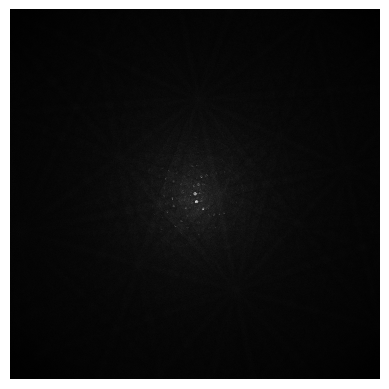

In [5]:
# generate_donut(phi1=137.4, Phi=54.8, phi2=199, path = "TestImages")
import time
start_time = time.time()  # get current time
generate_donut(phi1=round(random.uniform(0, 90), 1), Phi=round(random.uniform(0, 90),1), phi2=round(random.uniform(0, 90),1), path = "TestImages", mask_enabled = False )
end_time = time.time()  # get current time
elapsed_time = end_time - start_time  # elapsed time in seconds
print(f"Time taken: {elapsed_time:.2f} seconds")
# phi1=137.4, Phi=54.8, phi2=199, atom_nr = 64000, gridpoints = 6144, power_ilum = 0.27